In [305]:
import pandas as pd

df = pd.read_csv("septoctor_training_dataset_20k.csv")

df.shape
df.head(3)

df["sepsis_label"].value_counts(normalize=True)

df.dtypes

df.groupby("sepsis_label")[[
    "temperature_celsius",
    "hss_score",
    "apgar5_total"
]].mean()

,temperature_celsius,hss_score,apgar5_total
sepsis_label,,,
0,37.051154,0.724384,8.850464
1,37.304281,2.289527,6.057309


In [306]:
leakage_cols = [
    "mnrs_score",
    "hss_score",
    "apgar1_total",
    "apgar5_total"
]

[col for col in leakage_cols if col in df.columns]

"risk_level" in df.columns

False

In [307]:
y = df["sepsis_label"]

leakage_columns = [
    "sepsis_label",     # target itself
    "mnrs_score",       # rule-based score
    "hss_score",        # derived score
    "apgar1_total",     # derived total
    "apgar5_total"      # derived total
]

X = df.drop(columns=leakage_columns)

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

print("\nLeakage columns still present in X:")
print([col for col in leakage_columns if col in X.columns])

X.head(3)

Feature matrix shape: (20000, 39)
Target shape: (20000,)

Leakage columns still present in X:
[]


,prom_present,chorioamnionitis,foul_smelling_liquor,prolonged_labor,unbooked_pregnancy,maternal_uti_sti,meconium_stained_liquor,cotwin_iud,pv_examinations_count,prom_duration_hours,...,apgar1_respiration,apgar5_appearance,apgar5_pulse,apgar5_grimace,apgar5_activity,apgar5_respiration,gestational_age_category,birth_weight_category,resuscitation_required,neonatal_sex
0,1,0,0,0,0,0,1,0,2,6.236439,...,1,2,2,2,2,2,≥37,≥2500,0,female
1,0,1,1,0,1,1,1,0,3,0.040409,...,0,1,1,0,2,1,34–36,1500–2499,0,male
2,0,0,0,0,1,0,0,0,2,0.000000,...,2,1,2,1,2,2,34–36,≥2500,0,male


In [308]:
from sklearn.preprocessing import OneHotEncoder
import re
import pandas as pd

def sanitize_string(name):
    return re.sub(r'[<>[\]\W]', '_', name)

categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("Categorical columns to encode:")
print(categorical_cols)

ohe = OneHotEncoder(
    drop="first",
    sparse_output=False,
    handle_unknown="ignore"
)

X_cat_encoded = ohe.fit_transform(X[categorical_cols])

encoded_feature_names_raw = ohe.get_feature_names_out(categorical_cols)
sanitized_encoded_feature_names = [sanitize_string(name) for name in encoded_feature_names_raw]

X_cat_encoded_df = pd.DataFrame(
    X_cat_encoded,
    columns=sanitized_encoded_feature_names,
    index=X.index
)

X_numeric = X.drop(columns=categorical_cols)

X_encoded = pd.concat([X_numeric, X_cat_encoded_df], axis=1)

X_encoded.columns = [sanitize_string(col) for col in X_encoded.columns]

print("Encoded feature matrix shape:", X_encoded.shape)
print("Any object dtypes left?")
print(X_encoded.select_dtypes(include=["object"]).columns.tolist())

X_encoded.head(3)

Categorical columns to encode:
['gestational_age_category', 'birth_weight_category', 'neonatal_sex']
Encoded feature matrix shape: (20000, 41)
Any object dtypes left?
[]


,prom_present,chorioamnionitis,foul_smelling_liquor,prolonged_labor,unbooked_pregnancy,maternal_uti_sti,meconium_stained_liquor,cotwin_iud,pv_examinations_count,prom_duration_hours,...,apgar5_pulse,apgar5_grimace,apgar5_activity,apgar5_respiration,resuscitation_required,gestational_age_category__34,gestational_age_category__37,birth_weight_category__1500,birth_weight_category__2500,neonatal_sex_male
0,1,0,0,0,0,0,1,0,2,6.236439,...,2,2,2,2,0,0.0,1.0,0.0,1.0,0.0
1,0,1,1,0,1,1,1,0,3,0.040409,...,1,0,2,1,0,0.0,0.0,0.0,0.0,1.0
2,0,0,0,0,1,0,0,0,2,0.000000,...,2,1,2,2,0,0.0,0.0,0.0,1.0,1.0


In [309]:
from sklearn.model_selection import train_test_split

# 80 / 20 split with stratification on the label
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# Sanity Checks
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

print("\nLabel distribution (full):")
print(y.value_counts(normalize=True))

print("\nLabel distribution (train):")
print(y_train.value_counts(normalize=True))

print("\nLabel distribution (test):")
print(y_test.value_counts(normalize=True))

Train shape: (16000, 41)
Test shape: (4000, 41)

Label distribution (full):
sepsis_label
0    0.63095
1    0.36905
Name: proportion, dtype: float64

Label distribution (train):
sepsis_label
0    0.630938
1    0.369063
Name: proportion, dtype: float64

Label distribution (test):
sepsis_label
0    0.631
1    0.369
Name: proportion, dtype: float64


In [310]:
from sklearn.preprocessing import StandardScaler

# Identify continuous numeric columns to scale
continuous_cols = [
    "prom_duration_hours",
    "maternal_fever_celsius",
    "temperature_celsius",
    "heart_rate_bpm"
]

# Safety check: keep only columns that actually exist
continuous_cols = [c for c in continuous_cols if c in X_train.columns]

print("Continuous columns to scale:")
print(continuous_cols)

# Initialize scaler
scaler = StandardScaler()

# Create copies of X_train and X_test for scaling
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Fit scaler ONLY on training data and transform
X_train_scaled[continuous_cols] = scaler.fit_transform(
    X_train[continuous_cols]
)

# Apply the SAME scaler to test data
X_test_scaled[continuous_cols] = scaler.transform(
    X_test[continuous_cols]
)

# Sanity Checks
print("\nScaled train means (approx 0):")
print(X_train_scaled[continuous_cols].mean())

print("\nScaled train stds (approx 1):")
print(X_train_scaled[continuous_cols].std())

print("\nScaled test means (not exactly 0, expected):")
print(X_test_scaled[continuous_cols].mean())

X_train_scaled.head(3)

Continuous columns to scale:
['prom_duration_hours', 'maternal_fever_celsius', 'temperature_celsius', 'heart_rate_bpm']

Scaled train means (approx 0):
prom_duration_hours       5.595524e-17
maternal_fever_celsius    4.949152e-15
temperature_celsius       9.339196e-15
heart_rate_bpm           -3.801404e-16
dtype: float64

Scaled train stds (approx 1):
prom_duration_hours       1.000031
maternal_fever_celsius    1.000031
temperature_celsius       1.000031
heart_rate_bpm            1.000031
dtype: float64

Scaled test means (not exactly 0, expected):
prom_duration_hours       0.033307
maternal_fever_celsius    0.001353
temperature_celsius       0.034020
heart_rate_bpm           -0.013811
dtype: float64


,prom_present,chorioamnionitis,foul_smelling_liquor,prolonged_labor,unbooked_pregnancy,maternal_uti_sti,meconium_stained_liquor,cotwin_iud,pv_examinations_count,prom_duration_hours,...,apgar5_pulse,apgar5_grimace,apgar5_activity,apgar5_respiration,resuscitation_required,gestational_age_category__34,gestational_age_category__37,birth_weight_category__1500,birth_weight_category__2500,neonatal_sex_male
5736,0,0,1,0,1,0,0,0,4,-0.514594,...,1,2,0,1,0,0.0,0.0,0.0,0.0,0.0
2743,1,0,0,0,0,1,1,0,4,1.308791,...,2,2,0,1,0,0.0,1.0,1.0,0.0,1.0
1184,0,1,0,0,1,0,0,0,3,-0.514594,...,0,1,2,2,1,0.0,1.0,0.0,1.0,1.0


In [311]:
!pip install shap

In [312]:
import pandas as pd

df = pd.read_csv("septoctor_training_dataset_20k.csv")

df.shape
df.head(3)

df["sepsis_label"].value_counts(normalize=True)

df.dtypes

df.groupby("sepsis_label")[[
    "temperature_celsius",
    "hss_score",
    "apgar5_total"
]].mean()

,temperature_celsius,hss_score,apgar5_total
sepsis_label,,,
0,37.051154,0.724384,8.850464
1,37.304281,2.289527,6.057309


In [313]:
y = df["sepsis_label"]

leakage_columns = [
    "sepsis_label",     # target itself
    "mnrs_score",       # rule-based score
    "hss_score",        # derived score
    "apgar1_total",     # derived total
    "apgar5_total"      # derived total
]

X = df.drop(columns=leakage_columns)

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

print("\nLeakage columns still present in X:")
print([col for col in leakage_columns if col in X.columns])

X.head(3)

Feature matrix shape: (20000, 39)
Target shape: (20000,)

Leakage columns still present in X:
[]


,prom_present,chorioamnionitis,foul_smelling_liquor,prolonged_labor,unbooked_pregnancy,maternal_uti_sti,meconium_stained_liquor,cotwin_iud,pv_examinations_count,prom_duration_hours,...,apgar1_respiration,apgar5_appearance,apgar5_pulse,apgar5_grimace,apgar5_activity,apgar5_respiration,gestational_age_category,birth_weight_category,resuscitation_required,neonatal_sex
0,1,0,0,0,0,0,1,0,2,6.236439,...,1,2,2,2,2,2,≥37,≥2500,0,female
1,0,1,1,0,1,1,1,0,3,0.040409,...,0,1,1,0,2,1,34–36,1500–2499,0,male
2,0,0,0,0,1,0,0,0,2,0.000000,...,2,1,2,1,2,2,34–36,≥2500,0,male


In [314]:
from sklearn.preprocessing import OneHotEncoder
import re
import pandas as pd

def sanitize_string(name):
    return re.sub(r'[<>[\\]\\W]', '_', name)

categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("Categorical columns to encode:")
print(categorical_cols)

ohe = OneHotEncoder(
    drop="first",
    sparse_output=False,
    handle_unknown="ignore"
)

X_cat_encoded = ohe.fit_transform(X[categorical_cols])

encoded_feature_names_raw = ohe.get_feature_names_out(categorical_cols)
sanitized_encoded_feature_names = [sanitize_string(name) for name in encoded_feature_names_raw]

X_cat_encoded_df = pd.DataFrame(
    X_cat_encoded,
    columns=sanitized_encoded_feature_names,
    index=X.index
)

X_numeric = X.drop(columns=categorical_cols)

X_encoded = pd.concat([X_numeric, X_cat_encoded_df], axis=1)

X_encoded.columns = [sanitize_string(col) for col in X_encoded.columns]

print("Encoded feature matrix shape:", X_encoded.shape)
print("Any object dtypes left?")
print(X_encoded.select_dtypes(include=["object"]).columns.tolist())

X_encoded.head(3)

Categorical columns to encode:
['gestational_age_category', 'birth_weight_category', 'neonatal_sex']
Encoded feature matrix shape: (20000, 41)
Any object dtypes left?
[]


,prom_present,chorioamnionitis,foul_smelling_liquor,prolonged_labor,unbooked_pregnancy,maternal_uti_sti,meconium_stained_liquor,cotwin_iud,pv_examinations_count,prom_duration_hours,...,apgar5_pulse,apgar5_grimace,apgar5_activity,apgar5_respiration,resuscitation_required,gestational_age_category_<34,gestational_age_category_≥37,birth_weight_category_<1500,birth_weight_category_≥2500,neonatal_sex_male
0,1,0,0,0,0,0,1,0,2,6.236439,...,2,2,2,2,0,0.0,1.0,0.0,1.0,0.0
1,0,1,1,0,1,1,1,0,3,0.040409,...,1,0,2,1,0,0.0,0.0,0.0,0.0,1.0
2,0,0,0,0,1,0,0,0,2,0.000000,...,2,1,2,2,0,0.0,0.0,0.0,1.0,1.0


In [315]:
from sklearn.model_selection import train_test_split

# 80 / 20 split with stratification on the label
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# Sanity Checks
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

print("\nLabel distribution (full):")
print(y.value_counts(normalize=True))

print("\nLabel distribution (train):")
print(y_train.value_counts(normalize=True))

print("\nLabel distribution (test):")
print(y_test.value_counts(normalize=True))

Train shape: (16000, 41)
Test shape: (4000, 41)

Label distribution (full):
sepsis_label
0    0.63095
1    0.36905
Name: proportion, dtype: float64

Label distribution (train):
sepsis_label
0    0.630938
1    0.369063
Name: proportion, dtype: float64

Label distribution (test):
sepsis_label
0    0.631
1    0.369
Name: proportion, dtype: float64


In [316]:
from sklearn.preprocessing import StandardScaler

# Identify continuous numeric columns to scale
continuous_cols = [
    "prom_duration_hours",
    "maternal_fever_celsius",
    "temperature_celsius",
    "heart_rate_bpm"
]

# Safety check: keep only columns that actually exist
continuous_cols = [c for c in continuous_cols if c in X_train.columns]

print("Continuous columns to scale:")
print(continuous_cols)

# Initialize scaler
scaler = StandardScaler()

# Create copies of X_train and X_test for scaling
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Fit scaler ONLY on training data and transform
X_train_scaled[continuous_cols] = scaler.fit_transform(
    X_train[continuous_cols]
)

# Apply the SAME scaler to test data
X_test_scaled[continuous_cols] = scaler.transform(
    X_test[continuous_cols]
)

# Sanity Checks
print("\nScaled train means (approx 0):")
print(X_train_scaled[continuous_cols].mean())

print("\nScaled train stds (approx 1):")
print(X_train_scaled[continuous_cols].std())

print("\nScaled test means (not exactly 0, expected):")
print(X_test_scaled[continuous_cols].mean())

X_train_scaled.head(3)

Continuous columns to scale:
['prom_duration_hours', 'maternal_fever_celsius', 'temperature_celsius', 'heart_rate_bpm']

Scaled train means (approx 0):
prom_duration_hours       5.595524e-17
maternal_fever_celsius    4.949152e-15
temperature_celsius       9.339196e-15
heart_rate_bpm           -3.801404e-16
dtype: float64

Scaled train stds (approx 1):
prom_duration_hours       1.000031
maternal_fever_celsius    1.000031
temperature_celsius       1.000031
heart_rate_bpm            1.000031
dtype: float64

Scaled test means (not exactly 0, expected):
prom_duration_hours       0.033307
maternal_fever_celsius    0.001353
temperature_celsius       0.034020
heart_rate_bpm           -0.013811
dtype: float64


,prom_present,chorioamnionitis,foul_smelling_liquor,prolonged_labor,unbooked_pregnancy,maternal_uti_sti,meconium_stained_liquor,cotwin_iud,pv_examinations_count,prom_duration_hours,...,apgar5_pulse,apgar5_grimace,apgar5_activity,apgar5_respiration,resuscitation_required,gestational_age_category_<34,gestational_age_category_≥37,birth_weight_category_<1500,birth_weight_category_≥2500,neonatal_sex_male
5736,0,0,1,0,1,0,0,0,4,-0.514594,...,1,2,0,1,0,0.0,0.0,0.0,0.0,0.0
2743,1,0,0,0,0,1,1,0,4,1.308791,...,2,2,0,1,0,0.0,1.0,1.0,0.0,1.0
1184,0,1,0,0,1,0,0,0,3,-0.514594,...,0,1,2,2,1,0.0,1.0,0.0,1.0,1.0


In [317]:
import sys
!{sys.executable} -m pip install shap



Column names in X_train_scaled before RF fit:
['prom_present', 'chorioamnionitis', 'foul_smelling_liquor', 'prolonged_labor', 'unbooked_pregnancy', 'maternal_uti_sti', 'meconium_stained_liquor', 'cotwin_iud', 'pv_examinations_count', 'prom_duration_hours', 'maternal_fever_celsius', 'temperature_celsius', 'feeding_status', 'activity_level', 'respiratory_distress', 'heart_rate_bpm', 'apnea_present', 'shock_present', 'hss_tlc_abnormal', 'hss_anc_abnormal', 'hss_it_ratio_high', 'hss_im_ratio_high', 'hss_platelet_low', 'hss_neutrophil_degeneration', 'hss_nrbc_elevated', 'apgar1_appearance', 'apgar1_pulse', 'apgar1_grimace', 'apgar1_activity', 'apgar1_respiration', 'apgar5_appearance', 'apgar5_pulse', 'apgar5_grimace', 'apgar5_activity', 'apgar5_respiration', 'resuscitation_required', 'gestational_age_category_<34', 'gestational_age_category_≥37', 'birth_weight_category_<1500', 'birth_weight_category_≥2500', 'neonatal_sex_male']
Random Forest Results
---------------------
Train Accuracy: 0.

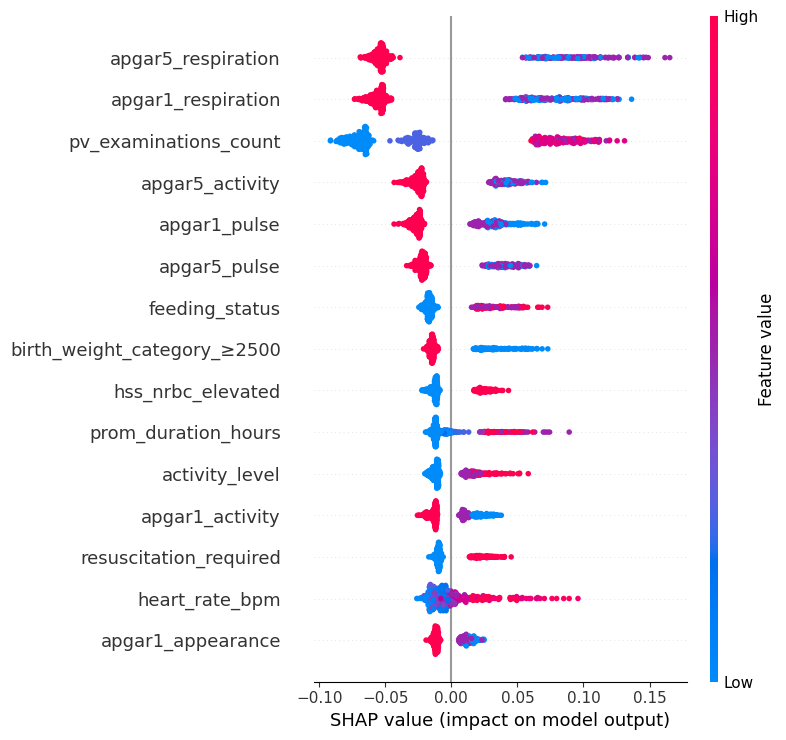

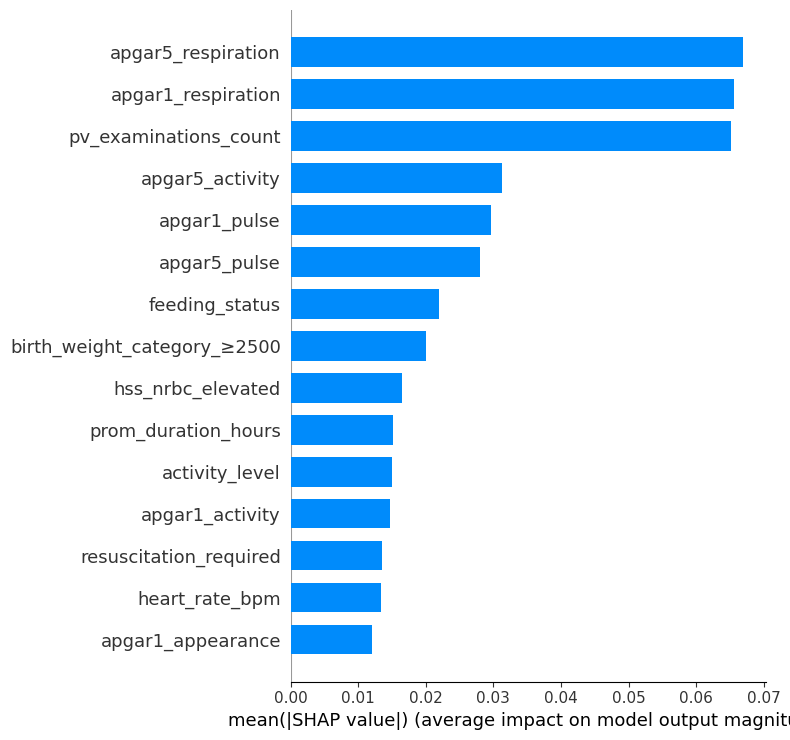

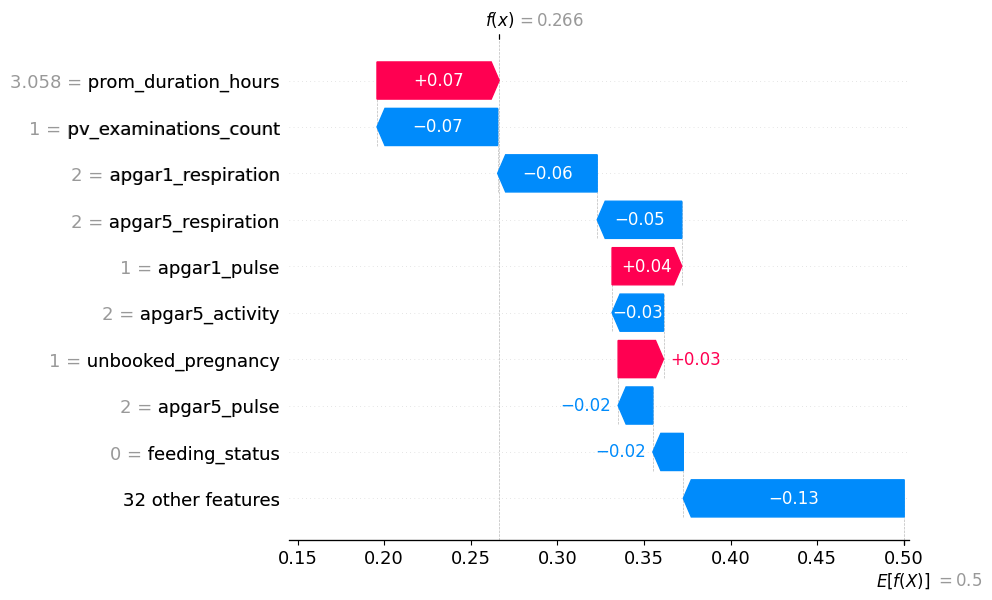

In [318]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import shap
import numpy as np # Ensure numpy is imported for array operations

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=20,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# Debugging: Print column names before training
print("\nColumn names in X_train_scaled before RF fit:")
print(X_train_scaled.columns.tolist())

# Train the Random Forest model on the scaled training data
rf_model.fit(X_train_scaled, y_train)

# Predict probabilities
y_train_prob_rf = rf_model.predict_proba(X_train_scaled)[:, 1]
y_test_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
rf_train_acc = accuracy_score(y_train, (y_train_prob_rf >= 0.5).astype(int))
rf_test_acc = accuracy_score(y_test, (y_test_prob_rf >= 0.5).astype(int))
rf_auc = roc_auc_score(y_test, y_test_prob_rf)

print("Random Forest Results")
print("---------------------")
print(f"Train Accuracy: {rf_train_acc:.4f}")
print(f"Test Accuracy : {rf_test_acc:.4f}")
print(f"ROC-AUC       : {rf_auc:.4f}")

# Use TreeExplainer for Random Forest
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values on a SAMPLE of training data (for speed)
X_shap = X_train_scaled.sample(500, random_state=42)

# Compute SHAP values for all classes. This will be a 3D array (n_samples, n_features, n_classes).
shap_values = explainer.shap_values(X_shap)

# Extract SHAP values for class 1 (sepsis_label=1) across all samples and features
# The output format for TreeExplainer for multi-output (binary classification here)
# is (n_samples, n_features, n_classes).
shap_values_class_1 = shap_values[:, :, 1]

# Summary Plot (dot)
shap.summary_plot(
    shap_values_class_1,
    X_shap,
    max_display=15,
    show=True
)

# Summary Plot (bar)
shap.summary_plot(
    shap_values_class_1,
    X_shap,
    plot_type="bar",
    max_display=15,
    show=True
)

# Pick a high-risk test sample (ensure index exists and corresponds to class 1)
positive_indices_test = y_test[y_test == 1].index
if not positive_indices_test.empty:
    idx_for_waterfall = positive_indices_test[0]
    X_single = X_test_scaled.loc[[idx_for_waterfall]]

    # Compute SHAP values for the single instance. This will also be (1, n_features, n_classes).
    shap_single = explainer.shap_values(X_single)

    # Extract SHAP values for class 1 for this single instance
    shap_single_class_1 = shap_single[:, :, 1]

    # Waterfall Plot for class 1
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_single_class_1[0], # Take the 1D array of values for the single instance
            base_values=explainer.expected_value[1],
            data=X_single.iloc[0],
            feature_names=X_single.columns
        )
    )
else:
    print("No positive samples found in test set for waterfall plot.")

In [319]:
from sklearn.metrics import classification_report, confusion_matrix

print("\nRandom Forest Classification Report")
print(classification_report(y_test, (y_test_prob_rf >= 0.5).astype(int)))


Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      2524
           1       0.71      0.76      0.73      1476

    accuracy                           0.80      4000
   macro avg       0.78      0.79      0.79      4000
weighted avg       0.80      0.80      0.80      4000



In [320]:
import joblib

# Save Random Forest model
joblib.dump(rf_model, "septoctor_rf_model.joblib")

# Save scaler
joblib.dump(scaler, "septoctor_scaler.joblib")

# Save OneHotEncoder
joblib.dump(ohe, "septoctor_ohe.joblib")

print("Saved model, scaler, and encoder successfully.")


Saved model, scaler, and encoder successfully.
